# GPT-Q

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
import torch
from pennylane import numpy as np

torch.set_printoptions(precision=3)

In [102]:
from models import QConv1d

ks = 5  # kind of arbitrary, limited by the number of available qubits
p = (ks - 1) // 2

qconv = QConv1d(kernel_size=ks, out_channels=3, n_qlayers=1, stride=1, padding=p)
qconv.draw()

 0: ──RX(0)──RX(2.51)──╭C──────────────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.39)──╰X──╭C──────────│───┤ ⟨Z⟩ 
 2: ──RX(0)──RX(2.11)──────╰X──╭C──────│───┤ ⟨Z⟩ 
 3: ──RX(0)──RX(5.71)──────────╰X──╭C──│───┤     
 4: ──RX(0)──RX(2.8)───────────────╰X──╰C──┤     



In [158]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.724, 0.739, 0.477, 0.790, 0.803, 0.830, 0.525, 0.619],
         [0.950, 0.038, 0.559, 0.566, 0.529, 0.111, 0.921, 0.880],
         [0.614, 0.241, 0.059, 0.060, 0.146, 0.071, 0.527, 0.055],
         [0.231, 0.916, 0.745, 0.830, 0.980, 0.313, 0.296, 0.817]]])


In [124]:
z = qconv(x)
print(z.shape)

torch.Size([1, 4, 8, 3])


In [125]:
z[:, :, :, 0].shape

torch.Size([1, 4, 8])

In [126]:
zc = z.view((1, 4, embed_dim*3))
print(zc.shape)

torch.Size([1, 4, 24])


1 + (c*w + 2*p - k) / s = w
=> (c*w - k) / s = w - 1
=> s = (c*w - k) / (w - 1)
this has to be an integer.

n = (c*w - k) / (w - 1) => n * (w - 1) = c*w - k => k = c*w - n * (w - 1)
k = (3 - n) * w + n, 0 < k < 3*w

In [128]:
def find_k(w, c):
    for n in range(10):
        # n = (b*w - k) / (d - 1) => n * (d - 1) = b*w - k => k = b*w - n*w + n
        k = c*w - n * (w - 1)
        if k < 0:
            break
        print(k)

find_k(embed_dim, 4)

32
25
18
11
4


In [111]:
ks_inv = 3
stride_inv = (3 * embed_dim - ks_inv) // (embed_dim - 1)
print(f"kernel size (=no. of qubits): {ks_inv}")
print(f"stride: {stride_inv}")
qconv_inv = QConv1d(kernel_size=ks_inv, out_channels=1, n_qlayers=1, stride=stride_inv, padding=0)
qconv_inv.draw()

kernel size (=no. of qubits): 3
stride: 3
 0: ──RX(0)──RX(4)─────╭C──────╭X──┤ ⟨Z⟩ 
 1: ──RX(0)──RX(5.23)──╰X──╭C──│───┤     
 2: ──RX(0)──RX(1.18)──────╰X──╰C──┤     



In [112]:
y = qconv_inv(zc).view((batch_size, seq_len, -1))
print(y.shape)

torch.Size([1, 4, 16])


In [190]:
x = torch.arange(24).view(1, 2, 4, 3)
print(x)

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8],
          [ 9, 10, 11]],

         [[12, 13, 14],
          [15, 16, 17],
          [18, 19, 20],
          [21, 22, 23]]]])


In [191]:
x = x.transpose(-1,-2).view(1,2,3,-1)
print(x)
x = x.reshape((1,2,12))
print(x)


tensor([[[[ 0,  3,  6,  9],
          [ 1,  4,  7, 10],
          [ 2,  5,  8, 11]],

         [[12, 15, 18, 21],
          [13, 16, 19, 22],
          [14, 17, 20, 23]]]])
tensor([[[ 0,  3,  6,  9,  1,  4,  7, 10,  2,  5,  8, 11],
         [12, 15, 18, 21, 13, 16, 19, 22, 14, 17, 20, 23]]])


In [168]:
print(zc)
zc.transpose(-1, -2)

tensor([[[ 0.442, -0.503,  0.480,  0.431, -0.795,  0.431,  0.586, -0.649,
           0.641,  0.852, -0.828,  0.821,  0.506, -0.971,  0.555,  0.372,
          -0.654,  0.404,  0.421, -0.611,  0.379,  0.507, -0.633,  0.561],
         [ 0.540, -0.503,  0.497,  0.548, -0.806,  0.511,  0.384, -0.712,
           0.398,  0.428, -0.592,  0.407,  0.542, -0.655,  0.460,  0.604,
          -0.728,  0.635,  0.577, -0.861,  0.571,  0.567, -0.755,  0.711],
         [ 0.408, -0.503,  0.346,  0.750, -0.630,  0.618,  0.773, -0.916,
           0.789,  0.720, -0.903,  0.795,  0.853, -0.930,  0.903,  0.748,
          -0.991,  0.957,  0.502, -0.980,  0.541,  0.510, -0.655,  0.637],
         [ 0.455, -0.503,  0.457,  0.861, -0.772,  0.748,  0.948, -0.993,
           0.989,  0.702, -0.987,  0.752,  0.481, -0.802,  0.522,  0.545,
          -0.715,  0.535,  0.716, -0.746,  0.722,  0.548, -0.942,  0.655]]],
       grad_fn=<ViewBackward>)


tensor([[[ 0.442,  0.540,  0.408,  0.455],
         [-0.503, -0.503, -0.503, -0.503],
         [ 0.480,  0.497,  0.346,  0.457],
         [ 0.431,  0.548,  0.750,  0.861],
         [-0.795, -0.806, -0.630, -0.772],
         [ 0.431,  0.511,  0.618,  0.748],
         [ 0.586,  0.384,  0.773,  0.948],
         [-0.649, -0.712, -0.916, -0.993],
         [ 0.641,  0.398,  0.789,  0.989],
         [ 0.852,  0.428,  0.720,  0.702],
         [-0.828, -0.592, -0.903, -0.987],
         [ 0.821,  0.407,  0.795,  0.752],
         [ 0.506,  0.542,  0.853,  0.481],
         [-0.971, -0.655, -0.930, -0.802],
         [ 0.555,  0.460,  0.903,  0.522],
         [ 0.372,  0.604,  0.748,  0.545],
         [-0.654, -0.728, -0.991, -0.715],
         [ 0.404,  0.635,  0.957,  0.535],
         [ 0.421,  0.577,  0.502,  0.716],
         [-0.611, -0.861, -0.980, -0.746],
         [ 0.379,  0.571,  0.541,  0.722],
         [ 0.507,  0.567,  0.510,  0.548],
         [-0.633, -0.755, -0.655, -0.942],
         [ 

## FeedForward

In [238]:
from models import FeedForward

ff = FeedForward(embed_dim, boom_factor=4, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [243]:
print("input:", x.shape)
xff = ff.forward(x)
print("output:", xff.shape)

input: torch.Size([1, 4, 8])
output: torch.Size([1, 4, 8])


## Attention

In [240]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.879, 0.937, 0.358, 0.162, 0.256, 0.023, 0.009, 0.436],
         [0.235, 0.610, 0.020, 0.139, 0.899, 0.573, 0.740, 0.396],
         [0.660, 0.636, 0.872, 0.478, 0.135, 0.023, 0.161, 0.089],
         [0.044, 0.458, 0.573, 0.727, 0.283, 0.855, 0.989, 0.085]]])


In [282]:
from models import MultiHeadAttention

n_heads = 2
n_qubits = 5
n_qlayers = 1
n_heads = 4

attn = MultiHeadAttention(embed_dim, n_heads, n_qubits, n_qlayers)

In [284]:
out = attn(x)
print("output of attention:", out.shape)

after qconv 1->3: torch.Size([1, 4, 8, 3])
shapes: q: torch.Size([1, 4, 8]) k: torch.Size([1, 4, 8]) v: torch.Size([1, 4, 8])
after split heads: torch.Size([1, 4, 4, 2]) torch.Size([1, 4, 4, 2]) torch.Size([1, 4, 4, 2])
attention: torch.Size([1, 4, 4, 2])
merged heads: torch.Size([1, 4, 8])
attn output: torch.Size([1, 4, 8])
output of attention: torch.Size([1, 4, 8])


## Transformer block

In [285]:
from models import TransformerBlock

transformer = TransformerBlock(embed_dim, n_heads=n_heads, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [286]:
x_tf = transformer.forward(x)
print("transformer block output:", x_tf.shape)

after qconv 1->3: torch.Size([1, 4, 8, 3])
shapes: q: torch.Size([1, 4, 8]) k: torch.Size([1, 4, 8]) v: torch.Size([1, 4, 8])
after split heads: torch.Size([1, 4, 4, 2]) torch.Size([1, 4, 4, 2]) torch.Size([1, 4, 4, 2])
attention: torch.Size([1, 4, 4, 2])
merged heads: torch.Size([1, 4, 8])
attn output: torch.Size([1, 4, 8])
transformer block output: torch.Size([1, 4, 8])


## GPT-Q Full Model

In [308]:
from models import GPTQ

batch_size = 1
max_seq_len = 16
src_vocab = 8
tgt_vocab = 4 
n_layers = 2
n_heads = 4

gptq = GPTQ(embed_dim=embed_dim, src_vocab=src_vocab, tgt_vocab=tgt_vocab, n_heads=n_heads, n_layers=n_layers)

In [309]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[4, 6, 1, 4, 5, 3, 6, 5, 1, 5, 1, 7, 1, 1, 6, 0]])


In [310]:
out = gptq(token_ids)
print("GPT-Q output:", out.shape)

after qconv 1->3: torch.Size([1, 16, 8, 3])
shapes: q: torch.Size([1, 16, 8]) k: torch.Size([1, 16, 8]) v: torch.Size([1, 16, 8])
after split heads: torch.Size([1, 4, 16, 2]) torch.Size([1, 4, 16, 2]) torch.Size([1, 4, 16, 2])
attention: torch.Size([1, 4, 16, 2])
merged heads: torch.Size([1, 16, 8])
attn output: torch.Size([1, 16, 8])
after qconv 1->3: torch.Size([1, 16, 8, 3])
shapes: q: torch.Size([1, 16, 8]) k: torch.Size([1, 16, 8]) v: torch.Size([1, 16, 8])
after split heads: torch.Size([1, 4, 16, 2]) torch.Size([1, 4, 16, 2]) torch.Size([1, 4, 16, 2])
attention: torch.Size([1, 4, 16, 2])
merged heads: torch.Size([1, 16, 8])
attn output: torch.Size([1, 16, 8])
output of transformer blocks: torch.Size([1, 16, 8])
logits: torch.Size([1, 16, 4])
GPT-Q output: torch.Size([1, 16, 4])


## Masks

In [317]:
import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_padding_mask, make_subsequent_mask, make_lookahead_mask

In [318]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[3, 1, 3, 2, 1, 4, 1, 6, 3, 2, 7, 3, 4, 2, 3, 6]])


In [329]:
make_padding_mask(token_ids)

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True]]])

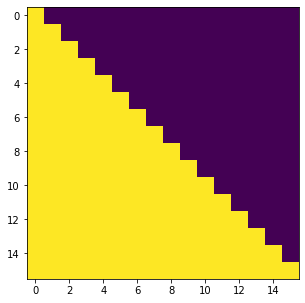

In [331]:
plt.figure(figsize=(5,5))
plt.imshow(make_subsequent_mask(max_seq_len)[0])

In [324]:
make_lookahead_mask(token_ids)

tensor([[[ True, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False,
          False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, Fal

## Train Classifier

In [438]:
from torchtext.datasets import IMDB

In [439]:
train_iter, test_iter = IMDB(split=('train', 'test'))

In [440]:
len(train_iter), len(test_iter)

(25000, 25000)

In [441]:
train_data = []
for label, line in train_iter:
    train_data.append(line)
print(train_data[:3])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [474]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

vocab_size = 5000
min_frequency = 2
special_tokens = [
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>",
    ]

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    min_frequency=min_frequency,
    special_tokens=special_tokens)

tokenizer.train_from_iterator(train_data, trainer=trainer)
tokenizer.save("gptq.json")

In [475]:
tokenizer.encode("Hello world").ids

[388, 559, 83, 1003]

## Fit Model

In [550]:
from models import GPTQ, IMDbClassifier

max_seq_len = 128
src_vocab = vocab_size
n_classes = 2
n_layers = 1
n_heads = 2

gptq = GPTQ(embed_dim=embed_dim, src_vocab=src_vocab, tgt_vocab=n_classes, n_heads=n_heads, n_layers=n_layers)
model = IMDbClassifier(gptq)

In [551]:
from dataset import IMDbDataModule

BATCH_SIZE = 32

dm = IMDbDataModule(val_split=0.2, batch_size=BATCH_SIZE, max_seq_length=max_seq_len)

In [ ]:
from pytorch_lightning import Trainer

AVAIL_GPUS = min(1, torch.cuda.device_count())

trainer = Trainer(
    max_epochs=2,
    gpus=AVAIL_GPUS,
    progress_bar_refresh_rate=20)
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPTQ | 48.3 K
-------------------------------
48.3 K    Trainable params
0         Non-trainable params
48.3 K    Total params
0.193     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/disipio/development/gpt-q/venv/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [ ]:
torch.save(model.state_dict(), "imdb_classifier.pt")

In [546]:
logits = torch.rand((BATCH_SIZE, n_classes))
targets = torch.randint(n_classes, size=(BATCH_SIZE,))

In [547]:
probs = F.log_softmax(logits, dim=-1)

In [548]:
F.nll_loss(probs, targets)

tensor(0.767)

In [549]:
loss = torch.nn.BCELoss()
loss(probs, targets)

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 2])) is deprecated. Please ensure they have the same size.